# Overview

## Imports and image loading

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image
from PIL import ImageFilter
import PIL.ImageOps
import numpy as np
from scipy import ndimage
from scipy import signal
from skimage.util import random_noise

In [2]:
cam = Image.open('cameraman.tif', mode='r').convert(mode="L")
lena = Image.open('lena.tiff', mode='r').convert(mode="L")
grayscale = Image.open('Grayscale.tif', mode='r').convert(mode="L")

In [3]:
def gaussian_noise(im, var=0.002):
    noisy = random_noise(np.array(im), mode='gaussian', var=var)
    return Image.fromarray(np.uint8(noisy*255))

def salt_pepper_noise(im, amount=0.05):
    noisy = random_noise(np.array(im), mode='s&p', amount=amount)
    return Image.fromarray(np.uint8(noisy*255))

def speckle_noise(im, var=0.04):
    noisy = random_noise(np.array(im), mode='speckle', var=var)
    return Image.fromarray(np.uint8(noisy*255))

In [4]:
def MSE(im1, im2):
    assert im1.size == im2.size and im1.mode == im2.mode
  
    im1_data = np.array(im1, dtype=np.int32).flatten()
    im2_data = np.array(im2, dtype=np.int32).flatten()
    
    M = len(im1_data)
    
    MSE = np.power(np.subtract(im1_data, im2_data), 2).sum() / M
    return MSE

def PSNR(im1, im2):
    assert im1.size == im2.size and im1.mode == im2.mode
    mse = MSE(im1, im2)
    if mse == 0:
        return math.inf
    return 10 * math.log10(65025.0 / mse) # 255^2 = 65025

def plot_histogram(im, title):
    im_hist = im.histogram()
    plt.bar([i for i in range(256)], im_hist)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

# Noise Generation

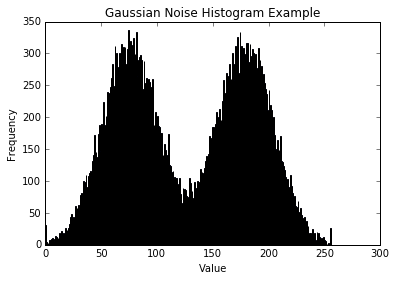

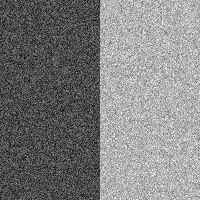

In [23]:
%matplotlib inline
grayscale_gaus = gaussian_noise(grayscale, 0.01)
plot_histogram(grayscale_gaus, "Gaussian Noise Histogram Example")
grayscale_gaus

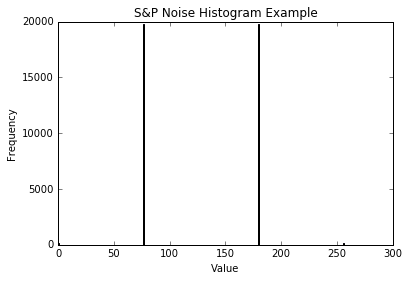

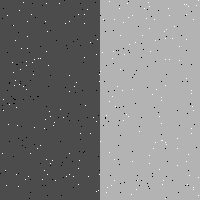

In [24]:
grayscale_sp = salt_pepper_noise(grayscale, 0.01)
plot_histogram(grayscale_sp, "S&P Noise Histogram Example")
grayscale_sp

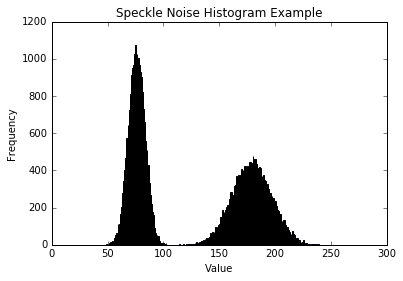

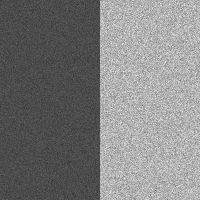

In [25]:
grayscale_speckle = speckle_noise(grayscale, 0.01)
plot_histogram(grayscale_speckle, "Speckle Noise Histogram Example")
grayscale_speckle

## Noise generation Questions

**1. Describe each of the histograms in the context of the corresponding noise models. Why do they appear
that way?**

_Gaussian Noise_: In the histogram, we see two gaussian distributions centered around the two grey values. This is because each pixel has some vallue added to it that is drawn from a gaussian distribution centered at zero.

_Salt & Pepper Noise_: We see the same peaks at the two original grey values, but we also see small peaks at 0 and 255 due to setting some pixels to black or white.

_Speckle Noise_: Similar to the gaussian noise, but instead of adding the noise directly, it multiplies the value by the value of the pixel before adding it. This is why the lighter peak has a wider and shorter distribution, as the multiplication by the higher value spreads out the distribution further apart. (skimage pulls the random number from a gaussian distribution instead of a uniform distribution which is what matlab does. If it pulled from uniform, we would see a taller narrower box centered at the darker peak and a shorter, wider rectangle centered at the lighter peak.)

**2. Are there visual differences between the noise contaminated images? What are they? Why?**

S&P Noise clearly shows black and white pixels because that's what it does. The gaussian and speckled images are much more similar. the gaussian image seems to have higher contrast with both lighter and darker pixels in each respective half, this is due to the wider distribution from which the noise is drawn.

**3. In the speckle noise case, what is the underlying distribution used? Can you tell from the histogram?
How?**

Pythons skimage library uses a gaussian distribution, unlike matlab which uses a uniform distribution. You can tell from the histogram as there are two gaussian distributions centered around the two peaks.

**4. In the speckle noise case, you will notice that the peaks of the histogram are no longer of the same
height as they were in the original image.  Also, the spread around each of the peaks is also different
from each other. Why? Hint: Noise is multiplicative.**

The formula for speckle noise is:

p_new = p + n*p

where p is the original pixel value and n is the random noise value. for larger p, the second term in that equation grows larger meaning you are changing your pixel value by a greater amount, hence the wider and shorter distribution.

# Noise Reduction in the Spatial Domain

PSNR between Lena and noisy Lena: 26.982310754414762


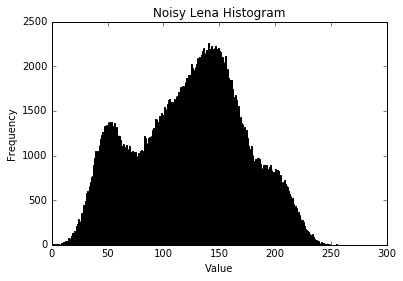

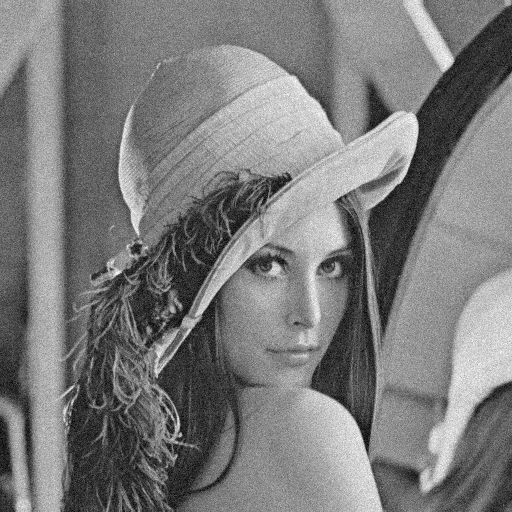

In [28]:
%matplotlib inline
noisy_lena = gaussian_noise(lena)
print("PSNR between Lena and noisy Lena: " + str(PSNR(lena, noisy_lena)))

plot_histogram(noisy_lena, "Noisy Lena Histogram")

noisy_lena

### Noisy lena convolved with 3x3 averaging filter:

3x3 averaging filter:


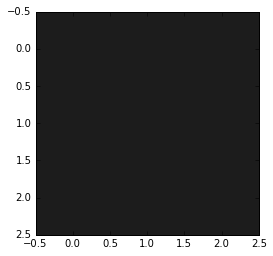

In [30]:
avg_3_3 = (1/9)*np.ones([3,3])

print("3x3 averaging filter:")
imshow(Image.fromarray(avg_3_3 *255))

noisy_lena_avg1 = Image.fromarray(ndimage.convolve(np.array(noisy_lena), avg_3_3), 'L')

PSNR between Lena and averaged Lena: 31.81900823285121

3x3 Gaussian Filter Result:


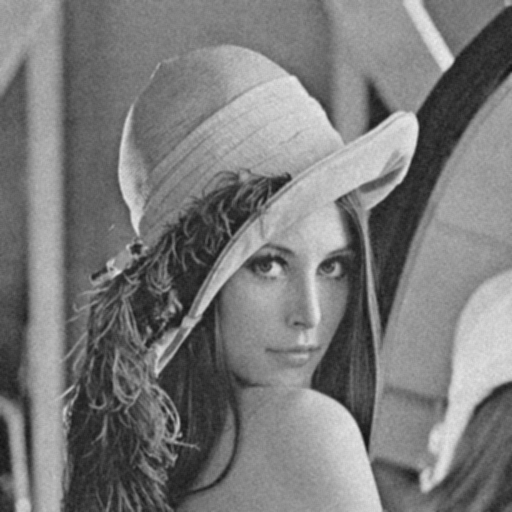

In [29]:
print("PSNR between Lena and averaged Lena: " + str(PSNR(lena, noisy_lena_avg1)) + "\n")

print("3x3 Gaussian Filter Result:")
noisy_lena_avg1

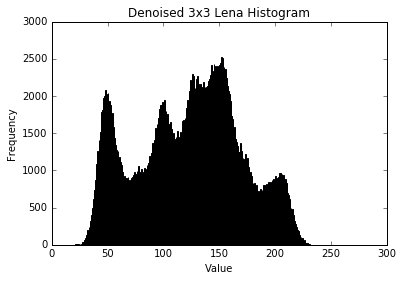

In [10]:
plot_histogram(noisy_lena_avg1, "Denoised 3x3 Lena Histogram")

### Noisy lena convolved with 7x7 averaging filter:

7x7 averaging filter:


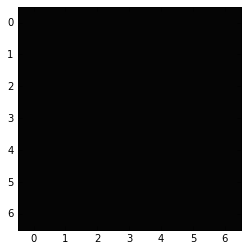

In [32]:
avg_7_7 = (1/(7*7))*np.ones([7,7])

print("7x7 averaging filter:")
imshow(Image.fromarray(avg_7_7 *255))

noisy_lena_avg2 = Image.fromarray(ndimage.convolve(np.array(noisy_lena), avg_7_7), 'L')

PSNR between Lena and averaged Lena: 27.394784706140506

7x7 Gaussian Filter Result:


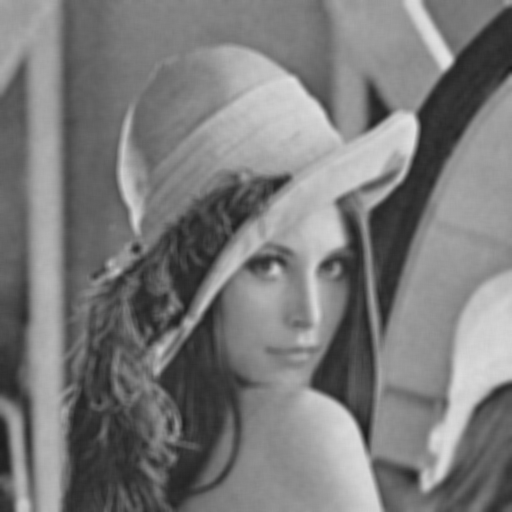

In [31]:
print("PSNR between Lena and averaged Lena: " + str(PSNR(lena, noisy_lena_avg2)) + "\n")
print("7x7 Gaussian Filter Result:")
noisy_lena_avg2

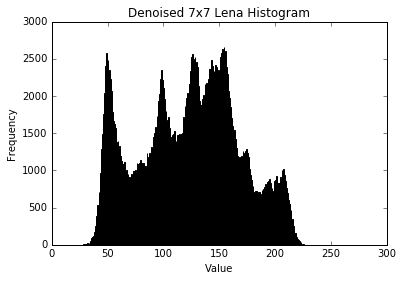

In [13]:
plot_histogram(noisy_lena_avg2, "Denoised 7x7 Lena Histogram")

### Gaussian 7x7 filter:

7x7 gaussian filter:


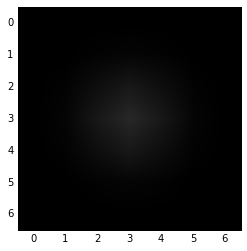

In [34]:
gaus =  np.array([[0.0000, 0.0002, 0.0011, 0.0018, 0.0011, 0.0002, 0.0000],
[0.0002, 0.0029, 0.0131, 0.0216, 0.0131, 0.0029, 0.0002],
[0.0011, 0.0131, 0.0586, 0.0966, 0.0586, 0.0131, 0.0011],
[0.0018, 0.0216, 0.0966, 0.1592, 0.0966, 0.0216, 0.0018],
[0.0011, 0.0131, 0.0586, 0.0966, 0.0586, 0.0131, 0.0011],
[0.0002, 0.0029, 0.0131, 0.0216, 0.0131, 0.0029, 0.0002],
[0.0000, 0.0002, 0.0011, 0.0018, 0.0011, 0.0002, 0.0000]]) # because python doesn't have an exact 'fspecial' equivalent

print("7x7 gaussian filter:")
imshow(Image.fromarray(gaus *255))

gaus_denoised = Image.fromarray(ndimage.convolve(np.array(noisy_lena), gaus), 'L')

PSNR between Lena and averaged Lena: 31.86368322855977

7x7 Gaussian Filter Result:


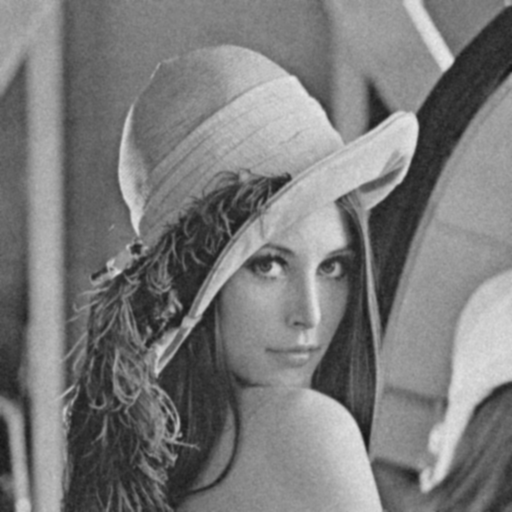

In [33]:
print("PSNR between Lena and averaged Lena: " + str(PSNR(lena, gaus_denoised)) + "\n")
print("7x7 Gaussian Filter Result:")
gaus_denoised

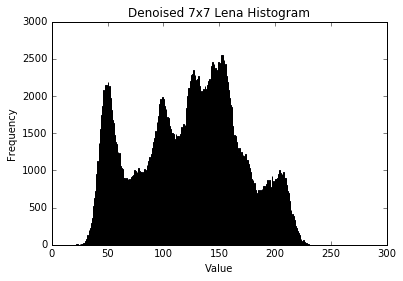

In [15]:
plot_histogram(gaus_denoised, "Denoised 7x7 Lena Histogram")

## Salt and Pepper Noise:

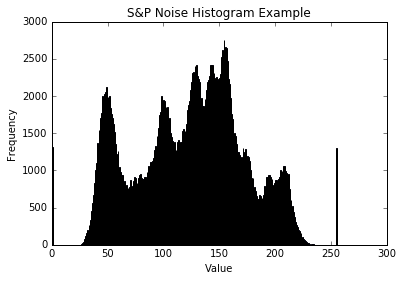

S&P Noise Image:


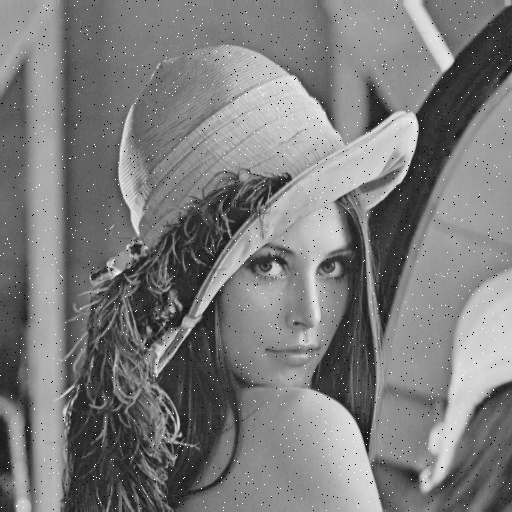

In [47]:
lena_sp = salt_pepper_noise(lena, 0.01)
plot_histogram(lena_sp, "S&P Noise Histogram Example")
print("S&P Noise Image:")
lena_sp

### Gaussian 7x7 Filter (S&P Noise):

PSNR between Lena and Gaussian De-S&P Lena: 31.36736264133937

S&P Denoised with Gaussian 7x7 Filter:


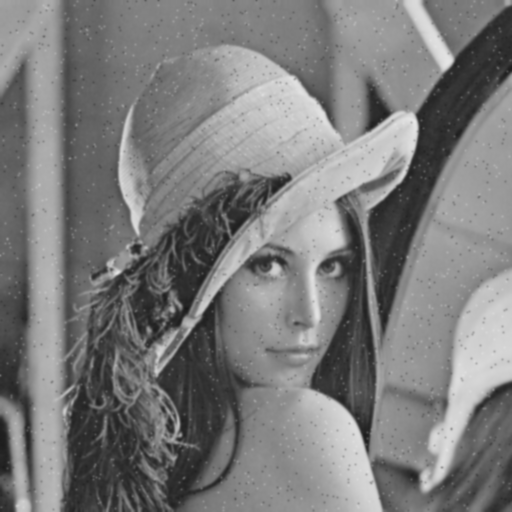

In [48]:
gaus =  np.array([[0.0000, 0.0002, 0.0011, 0.0018, 0.0011, 0.0002, 0.0000],
[0.0002, 0.0029, 0.0131, 0.0216, 0.0131, 0.0029, 0.0002],
[0.0011, 0.0131, 0.0586, 0.0966, 0.0586, 0.0131, 0.0011],
[0.0018, 0.0216, 0.0966, 0.1592, 0.0966, 0.0216, 0.0018],
[0.0011, 0.0131, 0.0586, 0.0966, 0.0586, 0.0131, 0.0011],
[0.0002, 0.0029, 0.0131, 0.0216, 0.0131, 0.0029, 0.0002],
[0.0000, 0.0002, 0.0011, 0.0018, 0.0011, 0.0002, 0.0000]]) # because python doesn't have an exact 'fspecial' equivalent

sp_denoised1 = Image.fromarray(ndimage.convolve(np.array(lena_sp), gaus), 'L')
print("PSNR between Lena and Gaussian De-S&P Lena: " + str(PSNR(lena, sp_denoised1)) + "\n")
print("S&P Denoised with Gaussian 7x7 Filter:")
sp_denoised1

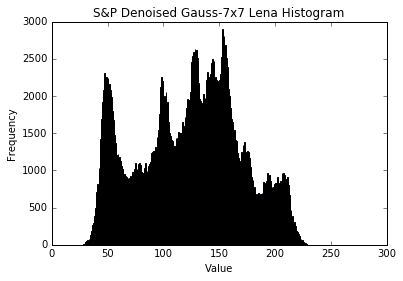

In [49]:
plot_histogram(sp_denoised1, "S&P Denoised Gauss-7x7 Lena Histogram")

### Averaging 7x7 Filter (Speckle Noise):

PSNR between Lena and Average De-S&P Lena: 27.305864899114674

S&P Denoised by 7x7 Average Filter:


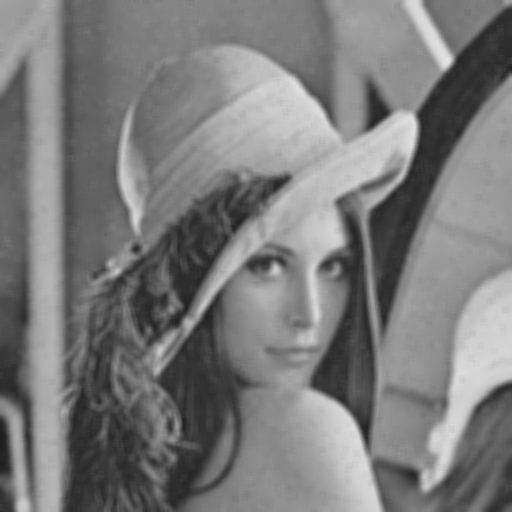

In [50]:
avg_7_7 = (1/(7*7))*np.ones([7,7])

sp_denoised2 = Image.fromarray(ndimage.convolve(np.array(lena_sp), avg_7_7), 'L')
print("PSNR between Lena and Average De-S&P Lena: " + str(PSNR(lena, sp_denoised2)) + "\n")
print("S&P Denoised by 7x7 Average Filter:")
sp_denoised2

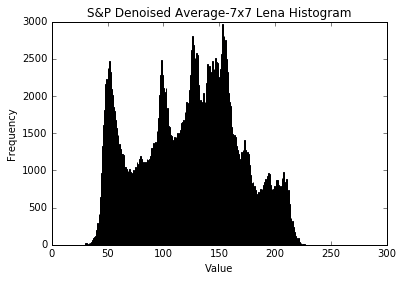

In [51]:
plot_histogram(sp_denoised2, "S&P Denoised Average-7x7 Lena Histogram")

## Median Filter

PSNR between Lena and averaged Lena: 31.55702687025261



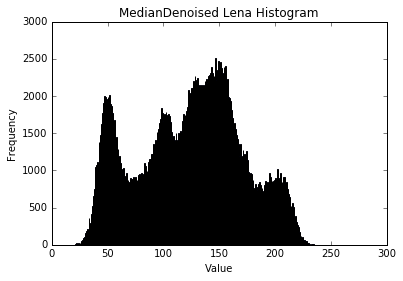

In [36]:
median_denoised = noisy_lena.filter(ImageFilter.MedianFilter())
print("PSNR between Lena and averaged Lena: " + str(PSNR(lena, median_denoised)) + "\n")
plot_histogram(median_denoised, "MedianDenoised Lena Histogram")

Median Filter Result:


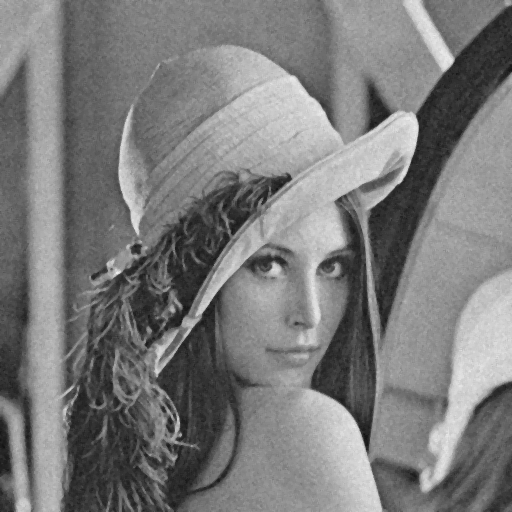

In [35]:
print("Median Filter Result:")
median_denoised

## Sharpening in Spatial Domain

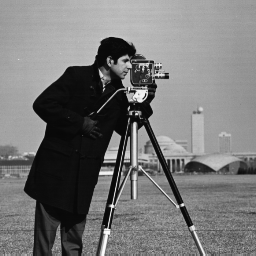

In [17]:
cam

Cameraman Image with Gaussian Filter:


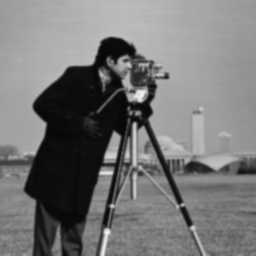

In [53]:
gaus_cam =  np.array([[0.0000, 0.0002, 0.0011, 0.0018, 0.0011, 0.0002, 0.0000],
[0.0002, 0.0029, 0.0131, 0.0216, 0.0131, 0.0029, 0.0002],
[0.0011, 0.0131, 0.0586, 0.0966, 0.0586, 0.0131, 0.0011],
[0.0018, 0.0216, 0.0966, 0.1592, 0.0966, 0.0216, 0.0018],
[0.0011, 0.0131, 0.0586, 0.0966, 0.0586, 0.0131, 0.0011],
[0.0002, 0.0029, 0.0131, 0.0216, 0.0131, 0.0029, 0.0002],
[0.0000, 0.0002, 0.0011, 0.0018, 0.0011, 0.0002, 0.0000]]) # because python doesn't have an exact 'fspecial' equivalent

gaus_cam_noised = Image.fromarray(ndimage.convolve(np.array(cam), gaus_cam), 'L')
print("Cameraman Image with Gaussian Filter:")
gaus_cam_noised

Subtracted Image:


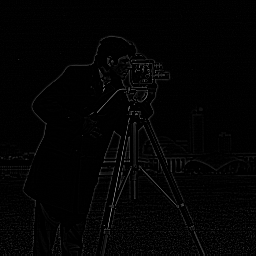

In [70]:
gaus_cam_array = np.array(gaus_cam_noised, dtype=np.int32)
cam_array = np.array(cam, dtype=np.int32)
sub_array = np.array((cam_array - gaus_cam_array).clip(min=0),dtype=np.uint8)
cam_sharp1 = Image.fromarray(sub_array)
print("Subtracted Image:")
cam_sharp1

**1. What does the subtracted image look like? What frequency components from the original image are preserved in the subtracted image? Why?**
The subtracted image looks like a black image of the original with only the edges outlined in white. The frequency components reserved from the original image are the edges. 

The image looks like this because the Gaussian filter is a smoothing function. This means that the edge values are smoothed out to more closer reflect the neighbours around them. A smoothing filter has little effect on large areas of solid colors as the neighbours are all already the same color. 

However when you subtract the Gaussian smoothed image from the original you get a lot of 0 values in areas where there is constant value. The values where there are changes are where edges occured. The sharper the edge the greater the difference between the smoothed pixel values and the original pixel values. This means sharper edges will be more illuminated. 

Subtracted Image Added to Original:


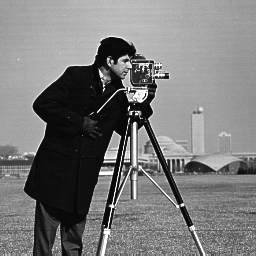

In [90]:
cam_sub_array = np.array(cam_sharp1, dtype=np.int32)
cam_addsub = np.array((np.array(cam_array,dtype=np.int32) + cam_sub_array).clip(max=255), dtype=np.uint8)
cam_sharp2 = Image.fromarray(cam_addsub)
print("Subtracted Image Added to Original:")
cam_sharp2

**1. What does the resulting image look like? How does it differ from the orginal image? Explain why it appears this way.**
The resulting image is an edge-enhanced version of the original image. Adding the subtracted version of the image from the earlier section means that those pixels on the edges getting a boost to their intensity. 

This differs from the original image because the pixel values of the edges are greater than they were before. Thus the edges are more illuminated and more noticeable than in the original. 

PSNR between Cam and Modified Cam: 43.86393214471096

Subtracted Image (0.5 variable) Added to Original:


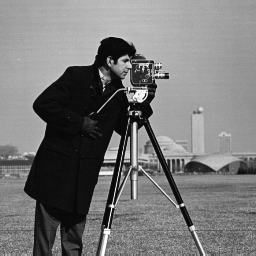

In [91]:
cam_sub_array2 = cam_sub_array ** 0.5
cam_addsub2 = cam_array + cam_sub_array2
cam_sharp3 = Image.fromarray(cam_addsub2)
cam_sharp4 = cam_sharp3.convert('L')
print("PSNR between Cam and Modified Cam: " + str(PSNR(cam, cam_sharp4)) + "\n")
print("Subtracted Image (0.5 variable) Added to Original:")
cam_sharp4

**1. Compare the results produced by adding the subtracting image to original image and that produced by adding half the subtrated image to the original image. How does it differ? Explain why it appears this why?**
The image is still edge enhanced but seemingly less than we had done originally. It differs because the edges are less sharp than they appear in the earlier edge enhanced version. This is because the edge pixels that where added to the original only had half the illumination as did in the earlier section. This means that the edge pixels where only given half as much as they were before. This is why the edges are less noticeable in the second than in the first. 

**2. What does multiplying the subtracted image by a factor less than one accomplish? What about greater than one?**
Multiplying the subtracted image by a factor less than one means that the edge enhancement or addition to the edges is halfed. This does not affect any of the '0' pixels because the multiplication has no affect on their final value. This means that the final image is only edge enhanced half as much as compared to our earlier attempt.

Multiplying by a factor greater than one means that the edge enhanced would be increased by whatever factor you multiplied by. For example if you multiplied by 2 then you would get double the edge enhancement. 